# 2nd part: Gridsearch and error analysis<br>
As mentioned before in the second part of this project we are going to attempt to improve the performance of the random forest with a grid search cross validation, trying out another strategy for filling NaNs and rebalancing the dataset. <br> 
Afterwards we are going to specifically analyse the incorrect predictions of the optimised random forest. We are going to try to find the kind of loans that were predicted incorrectly and try to understand the reason why the predictions were false.<br>
Following this we then will use this knowledge to attempt to improve performance.

The structure of the second part of this project is:

1. Importing required code from the previous part
2. Optimising the random forest with gridsearchCV
3. Error analysis
4. Interim result

# 1. Importing required code from the previous part

In [16]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv("https://github.com/TomMarq1/Credit_default_prediction_-ML-model-/raw/main/credit_risk_dataset.csv")

In [17]:
raw_df.drop_duplicates(inplace=True)

In [18]:
cleaned_df = raw_df.copy()
cleaned_df["person_emp_length"].fillna(0, inplace = True)

In [19]:
loan_grade_categories = ["A", "B", "C", "D", "E", "F", "G"]
corresp_avg_int_rates = cleaned_df.groupby("loan_grade").mean()["loan_int_rate"].to_list()

In [20]:
for i in range(len(loan_grade_categories)):

    
    x = cleaned_df[cleaned_df["loan_int_rate"].isna()].query("loan_grade == @loan_grade_categories[@i]")

    
    cleaned_df.loc[x.index, "loan_int_rate"] = corresp_avg_int_rates[i]
    
    
    

In [21]:
X = cleaned_df.drop(columns=["loan_status"])
y = cleaned_df["loan_status"]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [23]:
num_col = X_train.select_dtypes("number").columns.to_list()

In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_num_col_scaled = sc.fit_transform(X_train[num_col])
X_test_num_col_scaled = sc.transform(X_test[num_col])


In [25]:
cat_col = X_train.select_dtypes("object").columns.to_list()

In [26]:
non_ord_category_col = [cat_col[1]]

In [27]:
from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(sparse=False)
X_train_non_ord_cat_col_enc = ohenc.fit_transform(X_train[non_ord_category_col])
X_test_non_ord_cat_col_enc = ohenc.transform(X_test[non_ord_category_col])

In [28]:
ord_category_col = list((set(X_train.columns.to_list()) - set(num_col) - set(non_ord_category_col)))
ord_category_col



['cb_person_default_on_file', 'person_home_ownership', 'loan_grade']

In [29]:
from sklearn.preprocessing import OrdinalEncoder

cb_person_default_on_file_cats = ["Y", "N"]
loan_grade_cats =["G", "F", "E", "D", "C", "B", "A"]
person_home_ownership_cats = ["OTHER", "RENT", "MORTGAGE", "OWN"]

cats_ord = [cb_person_default_on_file_cats, person_home_ownership_cats, loan_grade_cats]
## for unkown reasons the order of the items in ord_category_col changes every time the notebook is run. This can lead to an error in cell [19]. 
## to resolve the error rearrange the item order in cats_ord in this cell according to the item order of ord_category_col in cell above

In [30]:
ord_enc = OrdinalEncoder(categories= cats_ord)
X_train_ord_cat_enc = ord_enc.fit_transform(X_train[ord_category_col])
X_test_ord_cat_enc = ord_enc.transform(X_test[ord_category_col])
# if error occurs check comment in cell above for fixing


In [31]:
X_train_processed = pd.concat([pd.DataFrame(X_train_num_col_scaled, #dataframe with scaled numerical columns
                               columns = num_col),
                               pd.DataFrame(X_train_non_ord_cat_col_enc, #dataframe with encoded non ordinal categorical columns
                               columns = ohenc.get_feature_names_out()),
                               pd.DataFrame(X_train_ord_cat_enc, # dataframe with encoded ordinal categorical columns
                               columns = ord_category_col) 

                               
                               ], axis=1)

In [32]:
X_test_processed = pd.concat([pd.DataFrame(X_test_num_col_scaled, #dataframe with scaled numerical columns
                               columns = num_col),
                               pd.DataFrame(X_test_non_ord_cat_col_enc, #dataframe with encoded non ordinal categorical columns
                               columns = ohenc.get_feature_names_out()),
                               pd.DataFrame(X_test_ord_cat_enc, # dataframe with encoded ordinal categorical columns
                               columns = ord_category_col) 

                               
                               ], axis=1)

# 2. Optimising the random forest with gridsearchCV
<br>
Now we try to improve the random forest by finding better hyperparameters for it. We use GridsearchCV for this task. GridearchCV tries out different kind of combinations of hyperparameters and sticks with the best performing ones.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [34]:
random_forest = RandomForestClassifier(random_state= 42)

In [35]:
random_forest_params = {"n_estimators" : [100, 150],
                        "max_depth"    : [10, 15, 20] ,
                        "min_samples_leaf" : [50, 80],
                        "min_samples_split" : [50,100]}


In [36]:
clf_GS = GridSearchCV(random_forest, random_forest_params, scoring ="accuracy", verbose= 1)

In [37]:
result_rf = clf_GS.fit(X_train_processed, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [38]:
result_rf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 100}

In [39]:
rf_pred_train = result_rf.predict(X_train_processed)

In [40]:
accuracy_score(rf_pred_train, y_train)

0.9271958045039884

In [41]:
accuracy_score(result_rf.predict(X_test_processed), y_test)

# The accuracy of the random forest optimised with gridsearch is slightly lower than the accuracy of a random forest with default values (92.7% vs 93.4%). 
# But the random forest with gridsearch is not overfitted to the train data and the results on the train data and test data are almost the same.
# This means the random forest with gridsearch has found a more generalised rule for its predictions because the found rule performs almost the same with the train data
# and the unknown test data. Therefore the random forest with the more generalised approach is more suited for predicting future loans because the more generalised rule 
# is more likely to be robust to future loans with a different range of values than the loans in the dataset.   

0.92719794344473

# 3 Applying a different strategy for filling in NaNs
<br>
There are a lot of possible strategies on how to fill in NaNs. <br>Because of the arguments mentioned in the first part, filling in NaNs in "person_emp_lenght" with 0 seems reasonable. Compared to this, filling in NaNs in "loan_int_rate" with the average interest rate of the corresponding "loan_grade" seems at least more arbitrary, so we are going to apply a different strategy of filling in those NaNs. Our strategy of choice is going to be the median of all the loans, to fill the NaNs with a value that is significantly different from our first approach. 

3.1 Applying a median strategy

In [42]:
import pandas as pd

raw_df = pd.read_csv("https://github.com/TomMarq1/Credit_default_prediction_-ML-model-/raw/main/credit_risk_dataset.csv")
raw_df.drop_duplicates(inplace=True)
cleaned_df = raw_df.copy()
cleaned_df["person_emp_length"].fillna(0, inplace = True)

In [43]:
# filling NaNs in "loan_grade" with the median of all loans
cleaned_df["loan_int_rate"].fillna(cleaned_df["loan_int_rate"].median(), inplace= True)


In [44]:
X = cleaned_df.drop(columns=["loan_status"])
y = cleaned_df["loan_status"]

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [46]:
num_col = X_train.select_dtypes("number").columns.to_list()

In [47]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_num_col_scaled = sc.fit_transform(X_train[num_col])
X_test_num_col_scaled = sc.transform(X_test[num_col])


In [48]:
cat_col = X_train.select_dtypes("object").columns.to_list()

In [49]:
non_ord_category_col = [cat_col[1]]

In [50]:
from sklearn.preprocessing import OneHotEncoder

ohenc = OneHotEncoder(sparse=False)
X_train_non_ord_cat_col_enc = ohenc.fit_transform(X_train[non_ord_category_col])
X_test_non_ord_cat_col_enc = ohenc.transform(X_test[non_ord_category_col])

In [51]:
ord_category_col = list((set(X_train.columns.to_list()) - set(num_col) - set(non_ord_category_col)))
ord_category_col

# for unkown reasons the order of the items in ord_category_col change every time the notebook is run. 
# This can lead to an error 2 cells below. 
# To resolve the error rearrange the item order in cats_ord in cell below according to the item order 
# of ord_category_col in this cell

['cb_person_default_on_file', 'person_home_ownership', 'loan_grade']

In [54]:
from sklearn.preprocessing import OrdinalEncoder

cb_person_default_on_file_cats = ["Y", "N"]
loan_grade_cats =["G", "F", "E", "D", "C", "B", "A"]
person_home_ownership_cats = ["OTHER", "RENT", "MORTGAGE", "OWN"]

cats_ord = [cb_person_default_on_file_cats, person_home_ownership_cats, loan_grade_cats]

In [55]:
ord_enc = OrdinalEncoder(categories= cats_ord)
X_train_ord_cat_enc = ord_enc.fit_transform(X_train[ord_category_col])
X_test_ord_cat_enc = ord_enc.transform(X_test[ord_category_col])
## if an error occurs executing this cell, look at the comment in the cell 2 above to resolve the problem

In [56]:
X_train_processed = pd.concat([pd.DataFrame(X_train_num_col_scaled, #dataframe with scaled numerical columns
                               columns = num_col),
                               pd.DataFrame(X_train_non_ord_cat_col_enc, #dataframe with encoded non ordinal categorical columns
                               columns = ohenc.get_feature_names_out()),
                               pd.DataFrame(X_train_ord_cat_enc, # dataframe with encoded ordinal categorical columns
                               columns = ord_category_col) 

                               
                               ], axis=1)

In [57]:
X_test_processed = pd.concat([pd.DataFrame(X_test_num_col_scaled, #dataframe with scaled numerical columns
                               columns = num_col),
                               pd.DataFrame(X_test_non_ord_cat_col_enc, #dataframe with encoded non ordinal categorical columns
                               columns = ohenc.get_feature_names_out()),
                               pd.DataFrame(X_test_ord_cat_enc, # dataframe with encoded ordinal categorical columns
                               columns = ord_category_col) 

                               
                               ], axis=1)

In [66]:
# To compare if our model performance is better with this strategy for filling in NaNs, we train the random forest with the exact hyperparameters found in the gridsearch above. 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
median_random_forest = RandomForestClassifier(random_state = 42, max_depth= 10, min_samples_leaf= 50, min_samples_split= 50, n_estimators= 100)

In [67]:
median_random_forest.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

In [68]:
accuracy_score(median_random_forest.predict(X_train_processed), y_train)

0.9271958045039884

In [69]:
accuracy_score(median_random_forest.predict(X_test_processed), y_test)

0.9278149100257069

3.2 Outcome
The simple median strategy surprisingly performed almost identical on the test data with an accuracy of 92.78% compared to the 92.76% with the previous strategy. Because of this we are going to stick with the median strategy because it is a more simple strategy.

# 4. Rebalancing the dataset
<br>
As we have already explored, about 21.8% of the loans are defaults. This means our dataset is imbalanced regarding the amount of non default loans compared to the defaults. There are almost 5 times more non default loans in the dataset as default loans. This imbalance is not caused by biased sampling or measurment errors but is a problem of the domain: If 50% of loans default, a bank would not stay in business for long...
<br>
The minority class, in our case default, is harder to predict because there are fewer examples of this class, by definition. This means it is more challenging for a model to learn the characteristics of examples from this class, and to differentiate examples from this class from the majority class (or classes). But this is not automatically the case. Whether the dataset contained enough instances of the minority class to learn to differentiate from the majority class can only be found out by testing which is what we are going to do in the following. 


4.1 Oversampling
<br>
Oversampling is a technique which increases the number of samples of the minority class up to the size of the majority class. This is done by generating synthetic samples. Different techniques can be applied to oversample a class. Here we will use RandomOverSampler.

In [ ]:
#!pip install imblearn


In [62]:
from imblearn.over_sampling import RandomOverSampler


In [71]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train_processed, y_train)

In [78]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=100, random_state=42)
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

In [79]:
accuracy_score(rf.predict(X_res), y_res)

0.8592381167693438

In [80]:
accuracy_score(rf.predict(X_test_processed), y_test)
# Random forest trained on dataset that was rebalanced by oversampling performed distinctly worse then on the original datase.

0.8940874035989718

4.2 Undersampling
<br>
Undersampling is a technique which decreases the number of samples of the majority class down to the size of the minority class. This is done by removing some samples from the majority class. Different techniques can be applied to undersample a class. Here we will use RandomUnderSampler.

In [83]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train_processed, y_train)

In [84]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50, n_estimators=100, random_state=42)
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

In [85]:
accuracy_score(rf.predict(X_res), y_res)

0.8410364145658263

In [86]:
accuracy_score(rf.predict(X_test_processed), y_test)
#The model also performed worse on a dataset that was undersampled 

0.8610796915167095

4.3 Outcome
<br>
Rebalancing the dataset could not improve the performance of the random forest, so we stick with the original dataset even though it´s an imbalanced one.

# 5. Error exploration

5.1 Overview <br>
To get a first impression what the false predictions look like, we use a confusion matrix for an overview. <br>
<br>
From this matrix below we can see that in the train dataset 1542 loans were predicted as non default by the random forest even though they actually defaulted (false negative) and 104 loans were predicted as default but in reality they did not default (false positive). <br>
<br>

c:\Users\gm-w\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


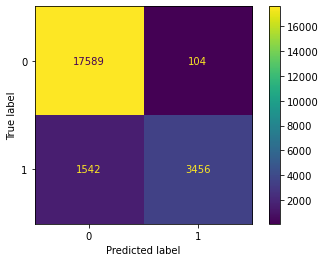

In [87]:
# to get an overview let´s see how the false predictions look like
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(result_rf, X_train_processed, y_train)

5.2 Exploring the incorrect predictions<br>
<br>
Now we are going to try to find out why these aforementioned loans were predicted incorrectly. To do so we are firstly going to attempt to consolidate the false predictions into groups with loans that have similar values. We do that because when all the loans in a group were predicted incorrectly and all of those loans have similar values, then it´s likely that these values are responsible for the wrong predictions.

To achieve the consolidation of the false predictions into similar groups, we make use of a decision tree. We are going to take the loans with the false predictions only and train a decision tree with them. The decision tree will automatically form the false predictions into similar groups for us by forming it´s leaves. When we are examining this decision tree, we are thus less interested in the prediction this tree made but in the leaves it created because those represent groups of similar loans that were predicted incorrectly by the previous random forest.  




In [88]:
# getting the false negative
# first create a copy of the train dataset, add the prediction of the random forest 
# and the true value for loan default to the train dataset
X_train_analysis = X_train_processed.copy()

X_train_analysis["rf_pred"] = rf_pred_train
X_train_analysis["true_outcome"] = y_train.tolist()
X_train_analysis

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file,person_home_ownership,loan_grade,rf_pred,true_outcome
0,2.597058,-0.014781,2.696150,-1.202739,-1.004600,-1.319334,2.029945,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,0,0
1,-0.430591,-0.298444,-0.865631,0.065842,-1.201964,0.276065,-0.688305,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,6.0,0,0
2,0.047459,-0.278790,1.746342,-1.186882,0.415774,-1.225487,-0.194077,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,0,1
3,-0.749291,0.268958,-0.865631,0.224415,0.558135,-0.287017,-0.688305,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,4.0,0,0
4,-0.908641,1.232155,-1.103083,0.858706,-0.668111,-0.568558,-0.935418,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,6.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22686,-0.749291,-0.279603,0.321629,0.620847,0.396361,0.839147,-0.935418,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0,0
22687,-0.111891,1.082341,-1.103083,0.577239,1.651727,-0.568558,0.300150,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,0,0
22688,-0.111891,-0.790333,-0.865631,-0.568449,-0.004838,0.745300,0.300150,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,0,0
22689,0.206809,0.193294,-0.628179,0.541561,-0.244263,-0.005476,0.547263,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0,0


[Text(0.6666666666666666, 0.9166666666666666, 'person_home_ownership <= 2.5\ngini = 0.122\nsamples = 1652\nvalue = [108, 1544]\nclass = y[1]'),
 Text(0.5555555555555556, 0.75, 'loan_grade <= 3.5\ngini = 0.064\nsamples = 1594\nvalue = [53, 1541]\nclass = y[1]'),
 Text(0.3333333333333333, 0.5833333333333334, 'loan_intent_MEDICAL <= 0.5\ngini = 0.294\nsamples = 291\nvalue = [52, 239]\nclass = y[1]'),
 Text(0.2222222222222222, 0.4166666666666667, 'person_income <= -0.626\ngini = 0.13\nsamples = 257\nvalue = [18, 239]\nclass = y[1]'),
 Text(0.1111111111111111, 0.25, 'gini = 0.457\nsamples = 34\nvalue = [12, 22]\nclass = y[1]'),
 Text(0.3333333333333333, 0.25, 'person_home_ownership <= 0.5\ngini = 0.052\nsamples = 223\nvalue = [6, 217]\nclass = y[1]'),
 Text(0.2222222222222222, 0.08333333333333333, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]\nclass = y[0]'),
 Text(0.4444444444444444, 0.08333333333333333, 'gini = 0.027\nsamples = 219\nvalue = [3, 216]\nclass = y[1]'),
 Text(0.4444444444444444,

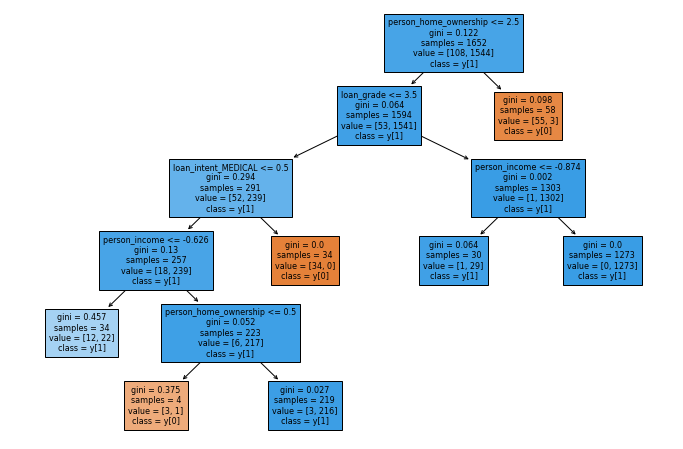

In [89]:
from matplotlib import pyplot as plt
from sklearn import tree as tr

# assing a new column "error" which has the value "True" in each row that was predicted incorrectly.
# Call the rows with "True" and store this dataframe only containing false predictions in a new variable. 
X_train_errors  = X_train_analysis.assign(error = lambda df_: df_['rf_pred'] != df_['true_outcome']).query('error')

# drop the columns that were added beforehand
X_train_errors.drop(columns=["rf_pred", 'error'], inplace=True)

# we want clusters large enough to work with, so we select corresponding hyperparameters to achieve this
error_tree = DecisionTreeClassifier(max_depth= 5, min_samples_split = 200)

# train and plot the tree
error_tree.fit(X_train_errors.drop(columns=['true_outcome']), X_train_errors['true_outcome'])

plt.figure(figsize=(12,8))
tr.plot_tree(error_tree, feature_names= error_tree.feature_names_in_, class_names= True, filled= True, fontsize= 8)

5.3 Analysing the errors<br>
<br>
As we can see the largest share of the incorrectly predicted loans are grouped into an entity of 1303 samples (we ignore the further split of this group because 1 leaf of the split has just 30 samples). <br>
<br>
This group with its 1303 samples represents 78,87% of all the 1652 false predictions.<br> All the loans of this group have in common that their value in "person_home_ownership" is equal to or below 2.5 and their value in "loan_grade" is above 3.5. This translates to borrowers that don´t own a home and have a loan grade of C or better (with A being the best). 
<br>
<br>
From this situation we can deduct 2 potential reasons for the false predictions <br>
<br>
The first reason is a more general one and appears every time NaN-values are filled before training a machine learning model. This is because every value used to fill in a NaN is basically a guess even though it might be a substantial one. That means there is always the threat of adding flawed information to the dataset when filling in NaNs which then can cause errors in the machine learning model later on. Thus there is a possibility that the way we filled in the NaNs is causing the prediction errors.
<br> 
<br>
The second potential reason for the false predictions could be that not we added flawed information to the dataset by filling in NaNs, but the original information already contained flawed information by itself in the first place.<br> 
Because all of the loans in the "error"-group have the values "person_home_ownership <= 2.5" and <br>
"loan_grade > 3.5", it is likely that at least one of this values contains flawed information which leads to false results when this value is used for default prediction. Because of this we are going to have a closer look at those 2 values: <br>
<br>
The value "person_home_ownership" <= 2.5 doesn´t give any indications, why this value could contain any flawed information which causes errors when used for loan default predictions. The inner message of this value is clear because it´s just a description if the borrowers own a house or not. Additionally it´s accountable how this specific value comes into existence simply by just checking of the borrower owns a house or not.
<br> 
<br>
On the contrary the inner meaning of the value "loan_grade > 3.5" is not clear. The data description on kaggle 
doesn´t provide an explanation on what the actual meaning of "loan_grade" is. One can only assume that "loan_grade" is some kind of aggregated evaluation of the quality and therby the default probability of the loan. Additionally it´s not clear how a specific value in "loan_grade" for each loan comes to be. Because of this and because most of the false predictions have a value "loan_grade > 3.5", we can have a founded suspicion that having a value in "loan_grade" > 3.5 contains flawed information about whether a loan defaults or not. 

 

# 4. Interim result
Through our error analysis we have isolated two potential reasons for the false predictions namely the filling in of the NaN values and having a value >3.5 in the column "loan_grade". In the next step we are going to test if those reasons were indeed responsible for the false predictions by finding a way of dealing with the potentially flawed informations and therby improving the performance of the model.
